In [1]:
# Load Libraries

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [80]:
# import sys
# import os
# scripts_path = os.path.abspath("../scripts")
# if scripts_path not in sys.path:
#     sys.path.append(scripts_path)

# from wrangle import wrangle
# df = wrangle("../data/air_quality_in_nairobi.csv")

# Load combined dataset

# file directory
file= "../data/Air_Quality_Lagos_Combined.csv"

# load into DataFrame
df = pd.read_csv(file, index_col="date", parse_dates=True)

# resampling the data to 1 hour interval
y = df["PM2.5"].resample('12h').mean().interpolate()

y.head()

date
2023-11-01 12:00:00+01:00    31.985714
2023-11-02 00:00:00+01:00    40.330000
2023-11-02 12:00:00+01:00    40.330000
2023-11-03 00:00:00+01:00    40.408893
2023-11-03 12:00:00+01:00     8.659795
Freq: 12h, Name: PM2.5, dtype: float64

In [81]:
# Size of the Dataset
shape = y.shape

print(f"The Shape of the Dataset is: {shape}")
print(f"The Dataset has: {shape[0]} historical data")
print(f"The number of missing data is: {y.isna().sum()}")
# print(f"The dataset have {shape[1]} column. For PM2.5 Readings")

The Shape of the Dataset is: (1034,)
The Dataset has: 1034 historical data
The number of missing data is: 0


In [82]:
# Data Split 
cutt_off = int(len(y) * 0.8)

train = y.iloc[:cutt_off]
test = y.iloc[cutt_off:]


# # train split
# train = y.loc[:"2024-11-24"]

# # test split
# test = y.loc["2024-11-25":]

print(f"Train split: {train.shape}")
print(f"Test split: {test.shape}")

Train split: (827,)
Test split: (207,)


# AR (AutoRegressive) Model

In [55]:
# Fit the AR model
ar_model = AutoReg(train, lags=29)  # for 24hours or 1 day
ar_result = ar_model.fit()

In [56]:
# Model summary
ar_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 1654
Model:                    AutoReg(29)   Log Likelihood               -6327.709
Method:               Conditional MLE   S.D. of innovations             11.882
Date:                Thu, 05 Jun 2025   AIC                          12717.417
Time:                        13:33:51   BIC                          12884.608
Sample:                    11-08-2023   HQIC                         12779.452
                         - 12-18-2024                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1558      0.670      3.220      0.001       0.844       3.468
PM2.5.L1       0.6608      0.025     26.740      0.000       0.612       0.709
PM2.5.L2       0.0993      0.029      3.366      0.001       0.041       0.157
PM2.5.L3      -0.0188      0.030     -0.636      0.525      -0.077       0.039
PM2.5.L4       0.1086      0.030      3.668      0.000       0.051       0.167
PM2.5.L5      -0.0183      0.030     -0.616      0.538      -0.076       0.040
PM2.5.L6      -0.0175      0.030     -0.590      0.555      -0.075       0.041
PM2.5.L7      -0.0490      0.030     -1.655      0.098      -0.107       0.009
PM2.5.L8       0.1926      0.030      6.499      0.000       0.135       0.251
PM2.5.L9      -0.1546      0.030     -5.151      0.000      -0.213      -0.096
PM2.5.L10     -0.0224      0.030     -0.740      0.459      -0.082       0.037
PM2.5.L11      0.0448      0.030      1.480      0.139      -0.015       0.104
PM2.5.L12      0.0964      0.030      3.187      0.001       0.037       0.156
PM2.5.L13     -0.1170      0.030     -3.864      0.000      -0.176      -0.058
PM2.5.L14      0.0010      0.030      0.032      0.974      -0.058       0.060
PM2.5.L15      0.0592      0.030      1.956      0.050      -0.000       0.118
PM2.5.L16      0.1122      0.030      3.707      0.000       0.053       0.172
PM2.5.L17     -0.0889      0.030     -2.938      0.003      -0.148      -0.030
PM2.5.L18     -0.0247      0.030     -0.816      0.415      -0.084       0.035
PM2.5.L19     -0.0240      0.030     -0.792      0.428      -0.083       0.035
PM2.5.L20      0.0271      0.030      0.897      0.370      -0.032       0.086
PM2.5.L21      0.0329      0.030      1.098      0.272      -0.026       0.092
PM2.5.L22     -0.0131      0.030     -0.443      0.658      -0.071       0.045
PM2.5.L23     -0.0005      0.030     -0.015      0.988      -0.058       0.058
PM2.5.L24      0.0920      0.030      3.111      0.002       0.034       0.150
PM2.5.L25     -0.0545      0.030     -1.839      0.066      -0.113       0.004
PM2.5.L26     -0.0050      0.030     -0.169      0.866      -0.063       0.053
PM2.5.L27     -0.0119      0.030     -0.402      0.688      -0.070       0.046
PM2.5.L28      0.1243      0.029      4.220      0.000       0.067       0.182
PM2.5.L29     -0.0870      0.025     -3.530      0.000      -0.135      -0.039
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0194           -0.0000j            1.0194           -0.5000
AR.2            -1.0529           -0.2392j            1.0797           -0.4644
AR.3            -1.0529           +0.2392j            1.0797            0.4644
AR.4            -0.9627           -0.4775j            1.0746           -0.4267
AR

In [57]:
# Forecast
y_ar_pred = ar_result.predict(test.index.min(), test.index.max())
y_ar_pred.head()


2024-12-19 00:00:00+01:00    49.213248
2024-12-19 06:00:00+01:00    48.259302
2024-12-19 12:00:00+01:00    47.276116
2024-12-19 18:00:00+01:00    48.321453
2024-12-20 00:00:00+01:00    48.848544
Freq: 6h, dtype: float64

In [58]:
# Baseline Model Metrics
mean = train.mean()
y_mean_pred = len(train) * [mean]

# MSE and MAE of the Baseline model
mse_baseline = mean_squared_error(train, y_mean_pred)
mae_baseline = mean_absolute_error(train, y_mean_pred)


print(f"MSE of the baseline model: {round(mse_baseline, 2)}")
print(f"MAE of the baseline model: {round(mae_baseline, 2)}")

MSE of the baseline model: 566.89
MAE of the baseline model: 16.69


In [59]:
# Evaluation
mse = mean_squared_error(test, y_ar_pred)
mae = mean_absolute_error(test, y_ar_pred)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

AR Model - MSE: 274.33
AR Model - MAE: 12.88


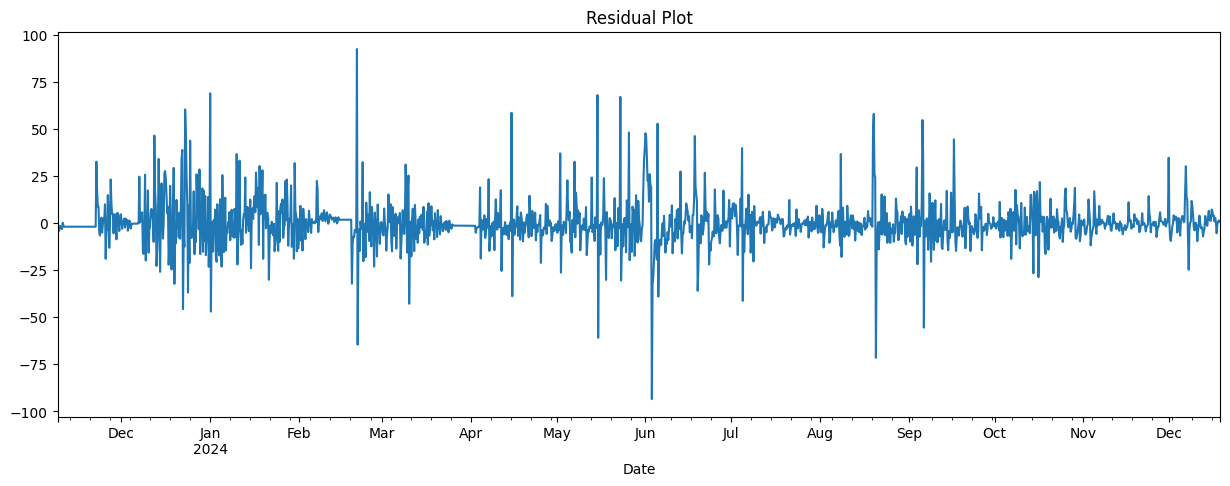

In [60]:
# Residual graph
fig, ax = plt.subplots(figsize = (15, 5))
ar_result.resid.plot(ax = ax)
plt.title("Residual Plot")
plt.xlabel("Date")
plt.show()

<Axes: title={'center': 'Residual Distribution'}, xlabel='Residual', ylabel='frequency'>

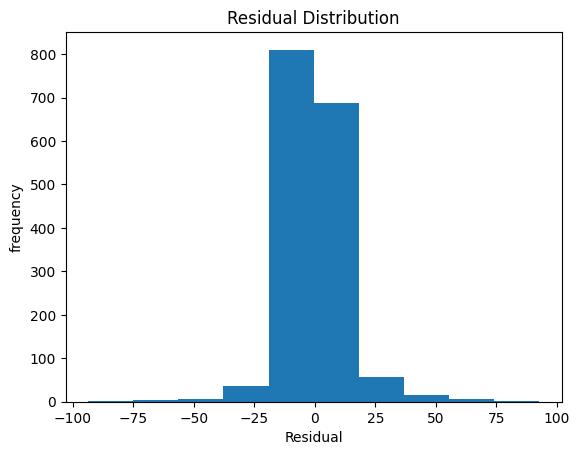

In [61]:
# Residual Histogram
ar_result.resid.plot(
    kind = "hist", 
    xlabel = "Residual",
    ylabel = "frequency",
    title = "Residual Distribution"
)

In [62]:
# DataFrame for Actual Test data and Predictions

df_pred_test = pd.DataFrame({
            'y_test':test,
            'y_pred':y_ar_pred
}, index = test.index)
df_pred_test.tail()

,y_test,y_pred
date,,
2025-03-31 06:00:00+01:00,8.761027,38.639962
2025-03-31 12:00:00+01:00,8.613270,38.639073
2025-03-31 18:00:00+01:00,8.465513,38.639077
2025-04-01 00:00:00+01:00,8.317757,38.639004
2025-04-01 06:00:00+01:00,8.170000,38.638482


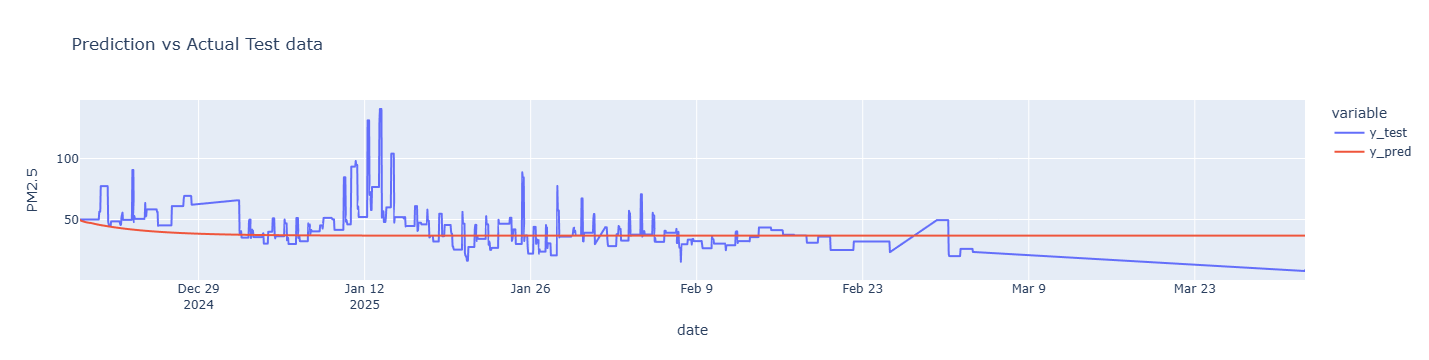

In [40]:
# Plot results
fig = px.line(
    data_frame= df_pred_test,
    title = "Prediction vs Actual Test data ",
    labels= {"value" : "PM2.5"}
)
fig.show()

In [64]:
# Walk Forward Validation

y_pred_wfv = pd.Series()
history = train.copy()
for i in range(len(test)):
    model = AutoReg(history, lags=29).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, test[next_pred.index]]) 


C:\Users\user\AppData\Local\Temp\ipykernel_6872\3190778413.py:8: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



In [65]:
df_pred_wfv = pd.DataFrame({
            'y_test':test,
            'y_pred':y_pred_wfv
}, index = test.index)
df_pred_wfv.tail()

,y_test,y_pred
date,,
2025-03-31 06:00:00+01:00,8.761027,10.734038
2025-03-31 12:00:00+01:00,8.613270,10.591023
2025-03-31 18:00:00+01:00,8.465513,10.447967
2025-04-01 00:00:00+01:00,8.317757,10.304871
2025-04-01 06:00:00+01:00,8.170000,10.161734


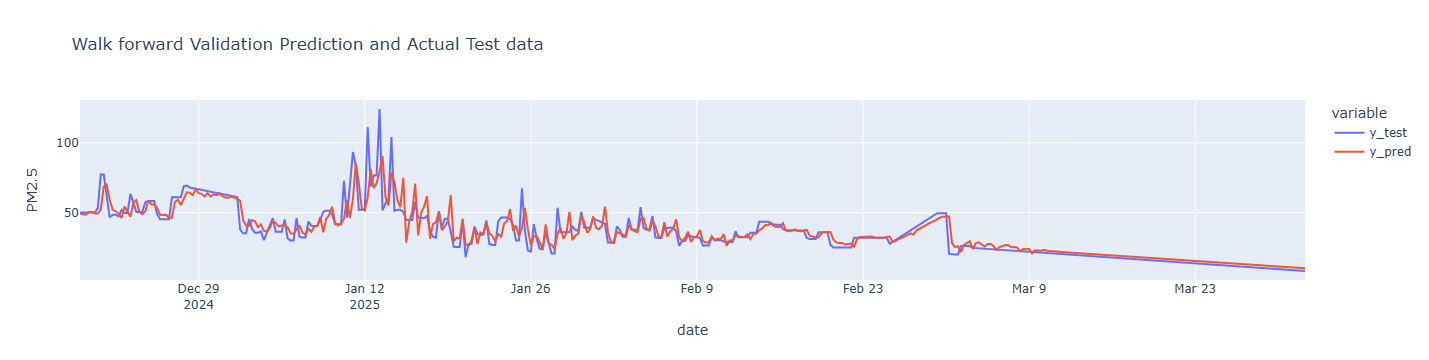

In [66]:
fig = px.line(
    data_frame= df_pred_wfv,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

In [67]:
# Evaluation of the Walk forward Validation Prediction

mse = mean_squared_error(test, y_pred_wfv)
mae = mean_absolute_error(test, y_pred_wfv)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

AR Model - MSE: 53.66
AR Model - MAE: 4.20


## Summary

The AR model Underperformed. why:
- The forecast (red line) is almost flat, failing to capture the volatility, spikes, and seasonality in the test set.
- AR models rely only on past values of the series (lags) and assume a linear relationship, which often fails when: There’s strong seasonality or nonlinearity.
- Residuals are not white noise, as we saw earlier from decomposition and ACF plots.



# ARMA (AutoRegressive Moving Average) Model

In [83]:
# Fit ARMA(p=2, q=2) on differenced data (you can tune p and q later)
arma_model = ARIMA(train, order=(2, 0, 2))  # d=0 because we assume stationary (you can test d=1 if needed)
arma_result = arma_model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [84]:
arma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                  827
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3237.250
Date:                Thu, 05 Jun 2025   AIC                           6486.500
Time:                        14:07:31   BIC                           6514.807
Sample:                    11-01-2023   HQIC                          6497.357
                         - 12-18-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.5125      3.726      9.799      0.000      29.210      43.815
ar.L1         -0.1397      0.017     -8.211      0.000      -0.173      -0.106
ar.L2          0.8396      0.017     50.531      0.000       0.807       0.872
ma.L1          0.9345      0.021     44.171      0.000       0.893       0.976
ma.L2          0.0142      0.023      0.629      0.529      -0.030       0.058
sigma2       146.7105      3.658     40.101      0.000     139.540     153.881
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3791.98
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
# Forecast
y_arma_pred = arma_result.predict(test.index.min(), test.index.max())
y_arma_pred.head()

2024-12-19 00:00:00+01:00    48.521258
2024-12-19 12:00:00+01:00    46.255375
2024-12-20 00:00:00+01:00    45.233789
2024-12-20 12:00:00+01:00    43.474107
2024-12-21 00:00:00+01:00    42.862225
Freq: 12h, Name: predicted_mean, dtype: float64

In [86]:
# Baseline Model Metrics
mean = train.mean()
y_mean_pred = len(train) * [mean]

# MSE and MAE of the Baseline model
mse_baseline = mean_squared_error(train, y_mean_pred)
mae_baseline = mean_absolute_error(train, y_mean_pred)


print(f"MSE of the baseline model: {round(mse_baseline, 2)}")
print(f"MAE of the baseline model: {round(mae_baseline, 2)}")

MSE of the baseline model: 517.93
MAE of the baseline model: 16.08


In [87]:
# Evaluation
mse = mean_squared_error(test, y_arma_pred)
mae = mean_absolute_error(test, y_arma_pred)

print(f"ARMA Model - MSE: {mse:.2f}")
print(f"ARMA Model - MAE: {mae:.2f}")

ARMA Model - MSE: 261.59
ARMA Model - MAE: 12.44


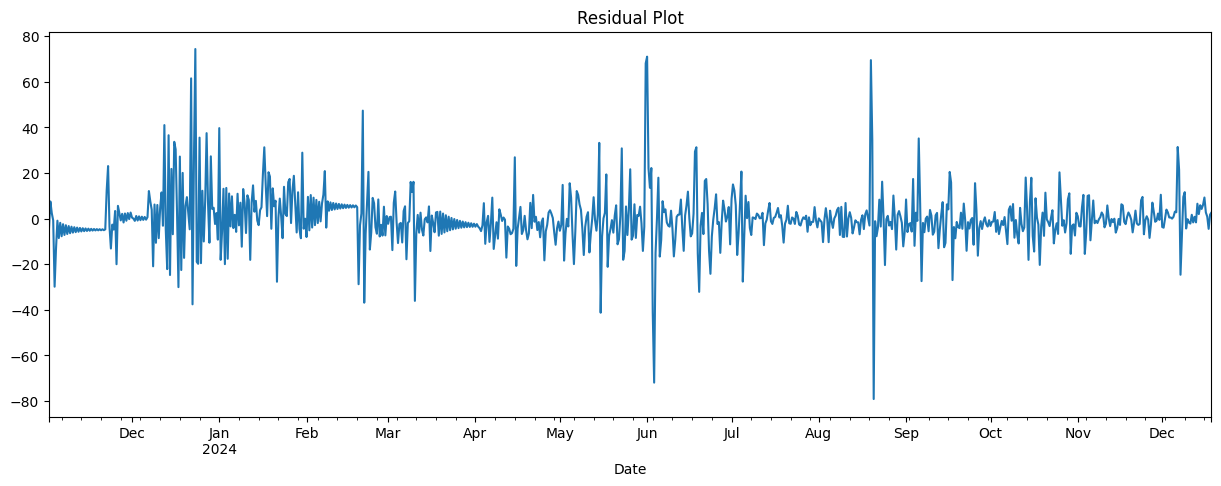

In [88]:
# Residual graph
fig, ax = plt.subplots(figsize = (15, 5))
arma_result.resid.plot(ax = ax)
plt.title("Residual Plot")
plt.xlabel("Date")
plt.show()

<Axes: title={'center': 'Residual Distribution'}, xlabel='Residual', ylabel='frequency'>

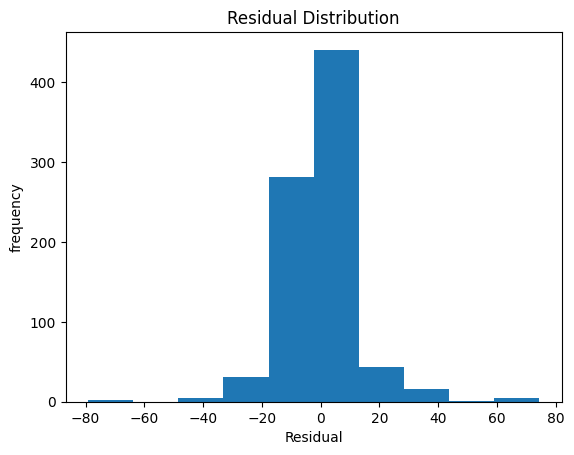

In [89]:
# Residual Histogram
arma_result.resid.plot(
    kind = "hist", 
    xlabel = "Residual",
    ylabel = "frequency",
    title = "Residual Distribution"
)

In [90]:
# DataFrame for Actual Test data and Predictions

df_pred_test = pd.DataFrame({
            'y_test':test,
            'y_pred':y_arma_pred
}, index = test.index)
df_pred_test.tail()

,y_test,y_pred
date,,
2025-03-30 00:00:00+01:00,9.420692,36.537854
2025-03-30 12:00:00+01:00,9.108019,36.487456
2025-03-31 00:00:00+01:00,8.795346,36.537289
2025-03-31 12:00:00+01:00,8.482673,36.488014
2025-04-01 00:00:00+01:00,8.170000,36.536737


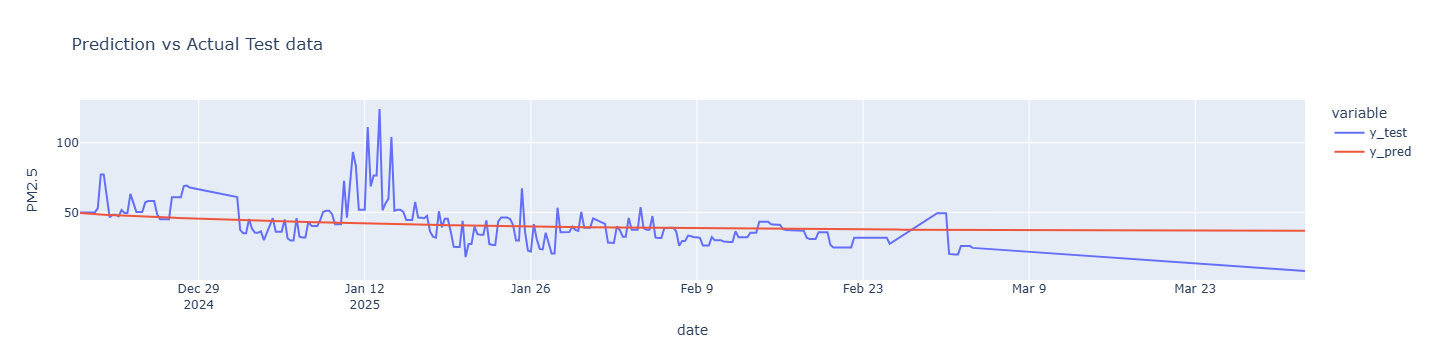

In [77]:
# Plot results
fig = px.line(
    data_frame= df_pred_test,
    title = "Prediction vs Actual Test data ",
    labels= {"value" : "PM2.5"}
)
fig.show()

In [ ]:
# Walk Forward Validation

y_pred_wfv = pd.Series()
history = train.copy()
for i in range(len(test)):
     model = ARIMA(history, order = (8, 0, 2)).fit()
     next_pred = model.forecast()
     y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
     history = pd.concat([history, test[next_pred.index]])


C:\Users\user\AppData\Local\Temp\ipykernel_6872\3622158175.py:8: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
df_pred_wfv = pd.DataFrame({
            'y_test':test,
            'y_pred':y_pred_wfv
}, index = test.index)
df_pred_wfv.tail()

In [ ]:
fig = px.line(
    data_frame= df_pred_wfv,
    title = "Walk forward Validation Prediction and Actual Test data",
    labels= {"value" : "PM2.5"}
)

fig.show()

In [ ]:
# Evaluation of the Walk forward Validation Prediction

mse = mean_squared_error(test, y_pred_wfv)
mae = mean_absolute_error(test, y_pred_wfv)

print(f"AR Model - MSE: {mse:.2f}")
print(f"AR Model - MAE: {mae:.2f}")

# ARIMA MODEL

In [ ]:
# Fit ARIMA
arima_model = ARIMA(train, order=(2, 1, 2))  # d=1 for first-order differencing
arima_result = arima_model.fit()

In [ ]:
# Forecast
y_pred_test = arima_result.predict(test.index.min(), test.index.max())
y_pred_test



In [ ]:
# Evaluation
mse = mean_squared_error(test, y_pred_test)
mae = mean_absolute_error(test, y_pred_test)

print(f"ARIMA Model - MSE: {mse:.2f}")
print(f"ARIMA Model - MAE: {mae:.2f}")


In [ ]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test, label="Actual", color='black')
plt.plot(y_pred_test, label="Forecast", color='green')
plt.title("ARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMA (Seasonal ARIMA) Model

In [ ]:
# Fit SARIMA
sarima_model = SARIMAX(train,
                       order=(2, 1, 2),
                       seasonal_order=(1, 1, 1, 44),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()


In [ ]:
# Forecast
y_pred_test = sarima_result.predict(test.index.min(), test.index.max())
y_pred_test


In [ ]:
# Evaluation
mse = mean_squared_error(test, y_pred_test)
mae = mean_absolute_error(test, y_pred_test)

print(f"SARIMA Model - MSE: {mse:.2f}")
print(f"SARIMA Model - MAE: {mae:.2f}")

In [ ]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(test, label="Actual", color='black')
plt.plot(y_pred_test, label="Forecast", color='blue')
plt.title("SARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()